# Imports and Data paths

In [1]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.optim as optim

import os
import cv2
import seaborn as sns

from metric_learning_utils import *
from metric_learning_trainer import fit

cuda = torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [25]:
TRIAN_DATA_PATH = "aicity_cars_dataset/train"
TEST_DATA_PATH = "aicity_cars_dataset/test"

train_classes = [ item for item in os.listdir(TRIAN_DATA_PATH) if os.path.isdir(os.path.join(TRIAN_DATA_PATH, item)) ]
test_classes = [ item for item in os.listdir(TEST_DATA_PATH) if os.path.isdir(os.path.join(TEST_DATA_PATH, item)) ]

train_colors = sns.color_palette(None, len(train_classes))
test_colors = sns.color_palette(None, len(test_classes))

train_classes_list = []
for i in range(len(train_classes)):
    train_classes_list.append(str(float(i)))
    train_classes_list.append(train_classes[i])

it = iter(train_classes_list)
train_classes_dct = dict(zip(it, it))

test_classes_list = []
for i in range(len(test_classes)):
    test_classes_list.append(str(float(i)))
    test_classes_list.append(test_classes[i])

it = iter(test_classes_list)
test_classes_dct = dict(zip(it, it))


# Prepare Dataset

In [3]:
batch_size = 32
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

img_transforms = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])

def load_split_train_test(TRIAN_DATA_PATH, TEST_DATA_PATH):
    train_data = ImageFolder(TRIAN_DATA_PATH,       
                    transform=img_transforms)
    test_data = ImageFolder(TEST_DATA_PATH,
                    transform=img_transforms)

    # Prepare triplet dataset
    triplet_train_dataset = TripletMIT_split(train_data, split='train', transform=img_transforms) # Returns triplet of images and target same/different
    triplet_test_dataset = TripletMIT_split(test_data, split='test', transform=img_transforms)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

    return train_loader, test_loader, triplet_train_loader, triplet_test_loader

train_loader, test_loader, triplet_train_loader, triplet_test_loader = load_split_train_test(TRIAN_DATA_PATH, TEST_DATA_PATH)

num_classes = len(train_loader.dataset.classes)

In [4]:
# Set up the network and training parameters

save_path = 'aicity_cars_metric_learning_results/metric_learning_ResNet18_sgd_TripletMarginLoss.pth'

## test different backbones
embedding_net = EmbeddingNet_V3('resnet18', '0')

model = TripletNet(embedding_net)

if cuda:
    model.cuda()

if not os.path.exists(save_path):
    if cuda:
        model.cuda()
        print('Cuda!!!')

    margin = 1.
    loss_fn = TripletLoss(margin)
    lr = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.5, last_epoch=-1)
    n_epochs = 50
    log_interval = 10
    ## Training !!!

    fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
    torch.save(model.state_dict(), save_path)
else:
    print('Loading model...')
    model.load_state_dict(torch.load(save_path))
    model.to(device)

Using cache found in /home/group05/.cache/torch/hub/pytorch_vision_v0.10.0


Loading model...


In [5]:
# Get embedding from train and test
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model, 512)
test_embeddings_cl, test_labels_cl = extract_embeddings(test_loader, model, 512)

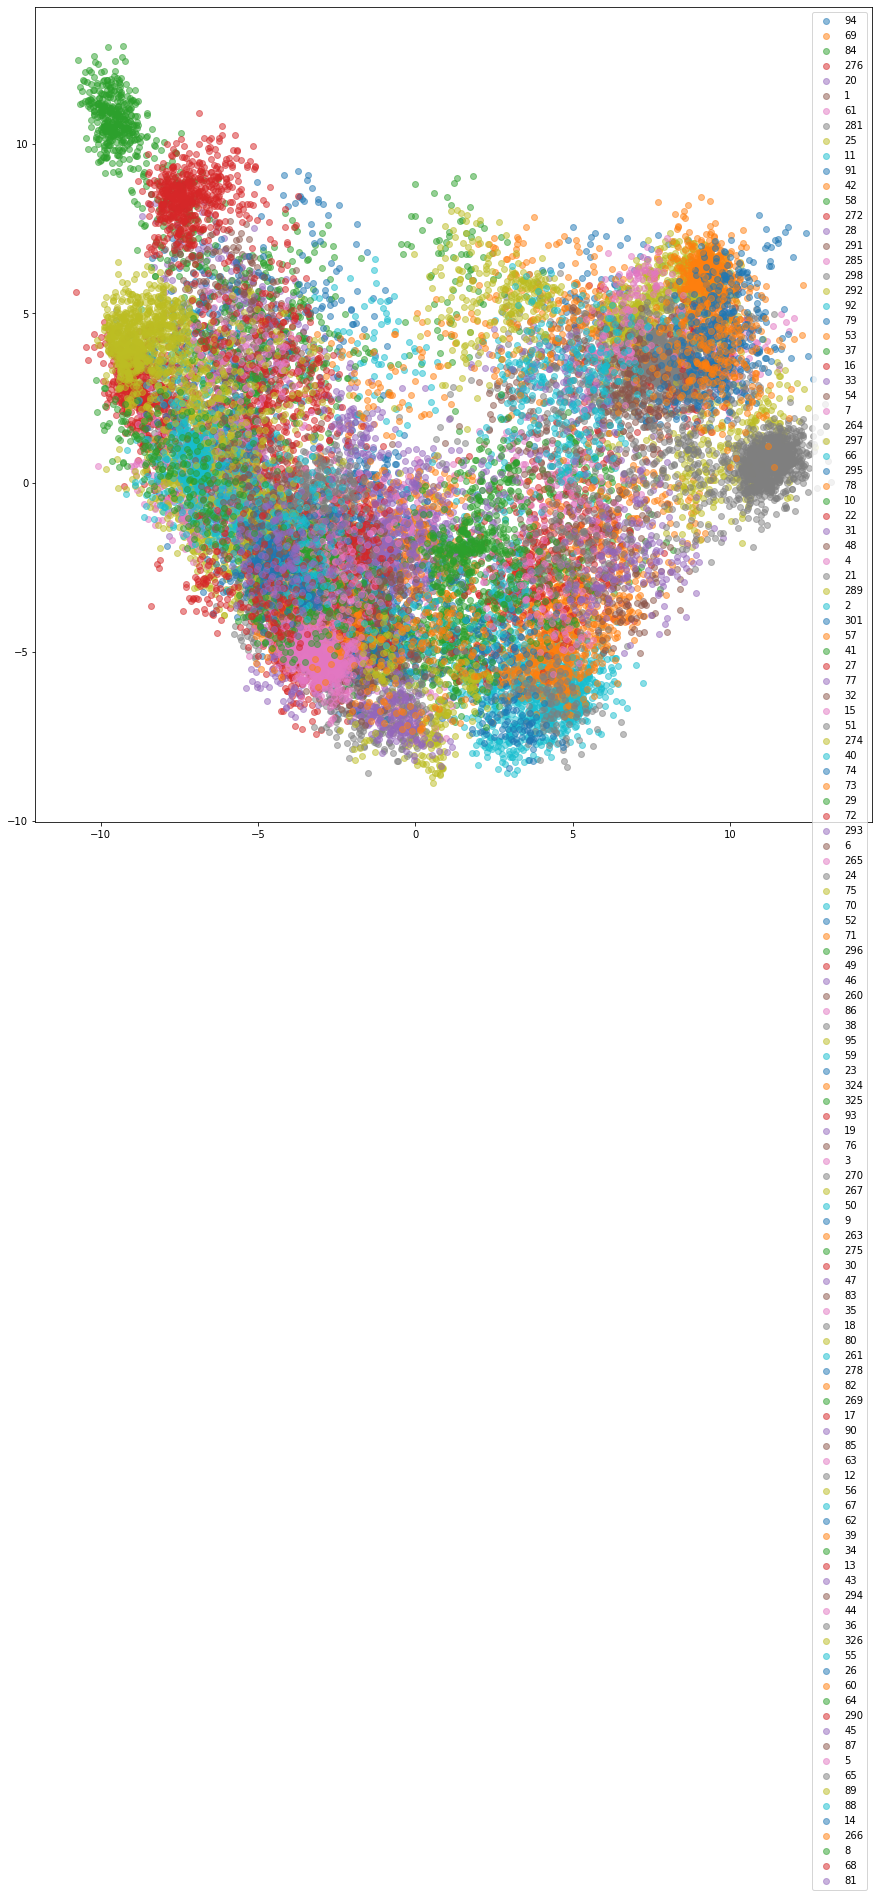

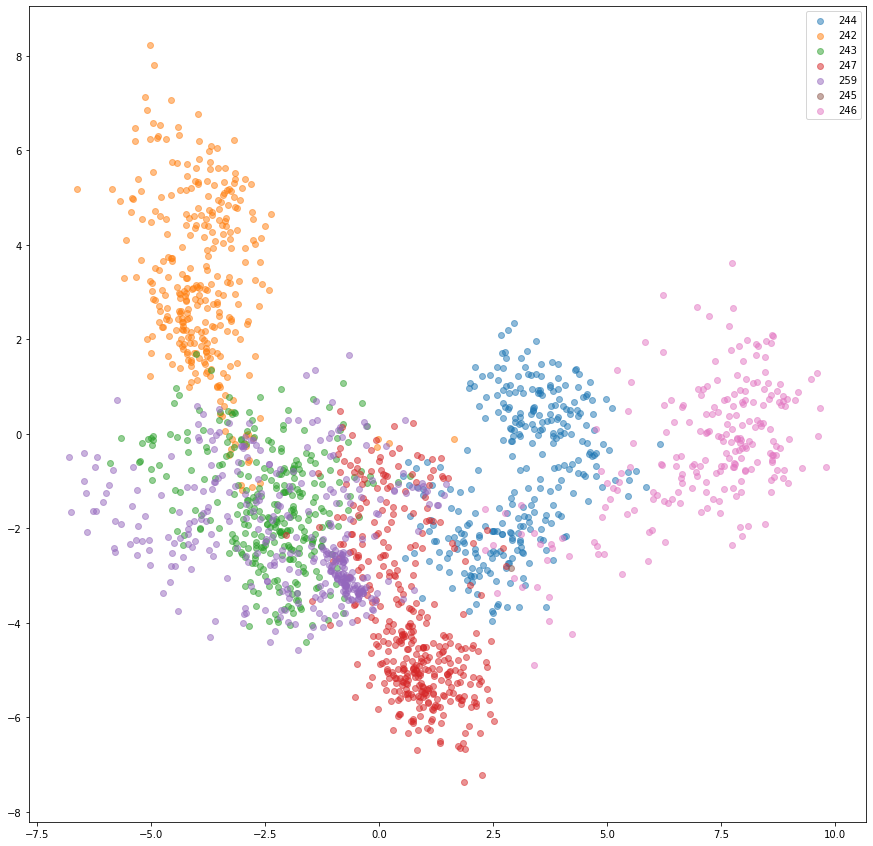

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(train_embeddings_cl)

#train embeddings
plot_embeddings(components, train_labels_cl, train_classes, train_colors, n_classes=len(train_classes))

#test embedings
test_comp = pca.transform(test_embeddings_cl)
plot_embeddings(test_comp, test_labels_cl, test_classes, test_colors, n_classes=len(test_classes))

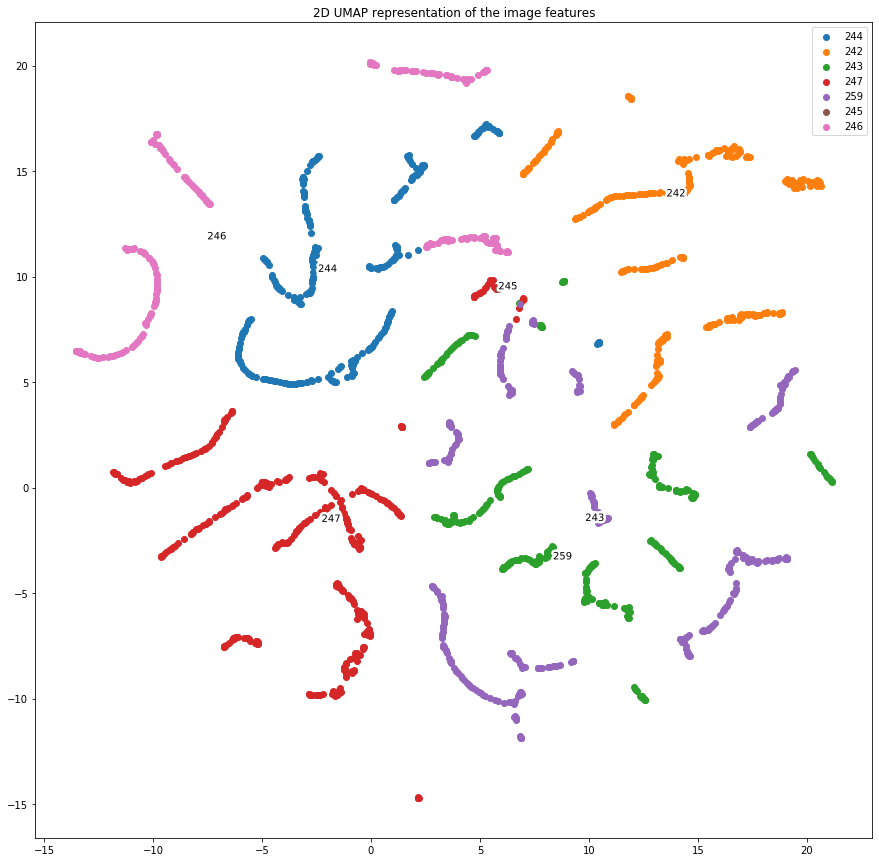

In [27]:
# compute the umap image representation
import umap.umap_ as umap
import matplotlib.patheffects as PathEffects

def plot_embeddings_umap(embeddings_cl, labels_cl, classes_dct):
        plt.figure(figsize=(15,15))
        embedding = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(embeddings_cl)
        labels = np.unique(labels_cl)

        for idx, label in enumerate(labels):
            label_features = [embedding[i] for i, x in enumerate(labels_cl) if x == label]
            plt.scatter(
                [x[0] for x in label_features],
                [x[1] for x in label_features],
                c=np.array([train_colors[idx]]),
                label=f'{classes_dct[str(label)]}',
                # s=np.ones(len(test_classes)),
            )

        plt.legend(loc='best')

        for idx, label in enumerate(labels):
            label_features = [embedding[i] for i, x in enumerate(labels_cl) if x == label]
            xtext, ytext = np.median(label_features, axis=0)
            txt = plt.text(xtext, ytext, classes_dct[str(float(idx))])
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])

        plt.title('2D UMAP representation of the image features')
        plt.show()

plot_embeddings_umap(test_embeddings_cl, test_labels_cl, test_classes_dct)

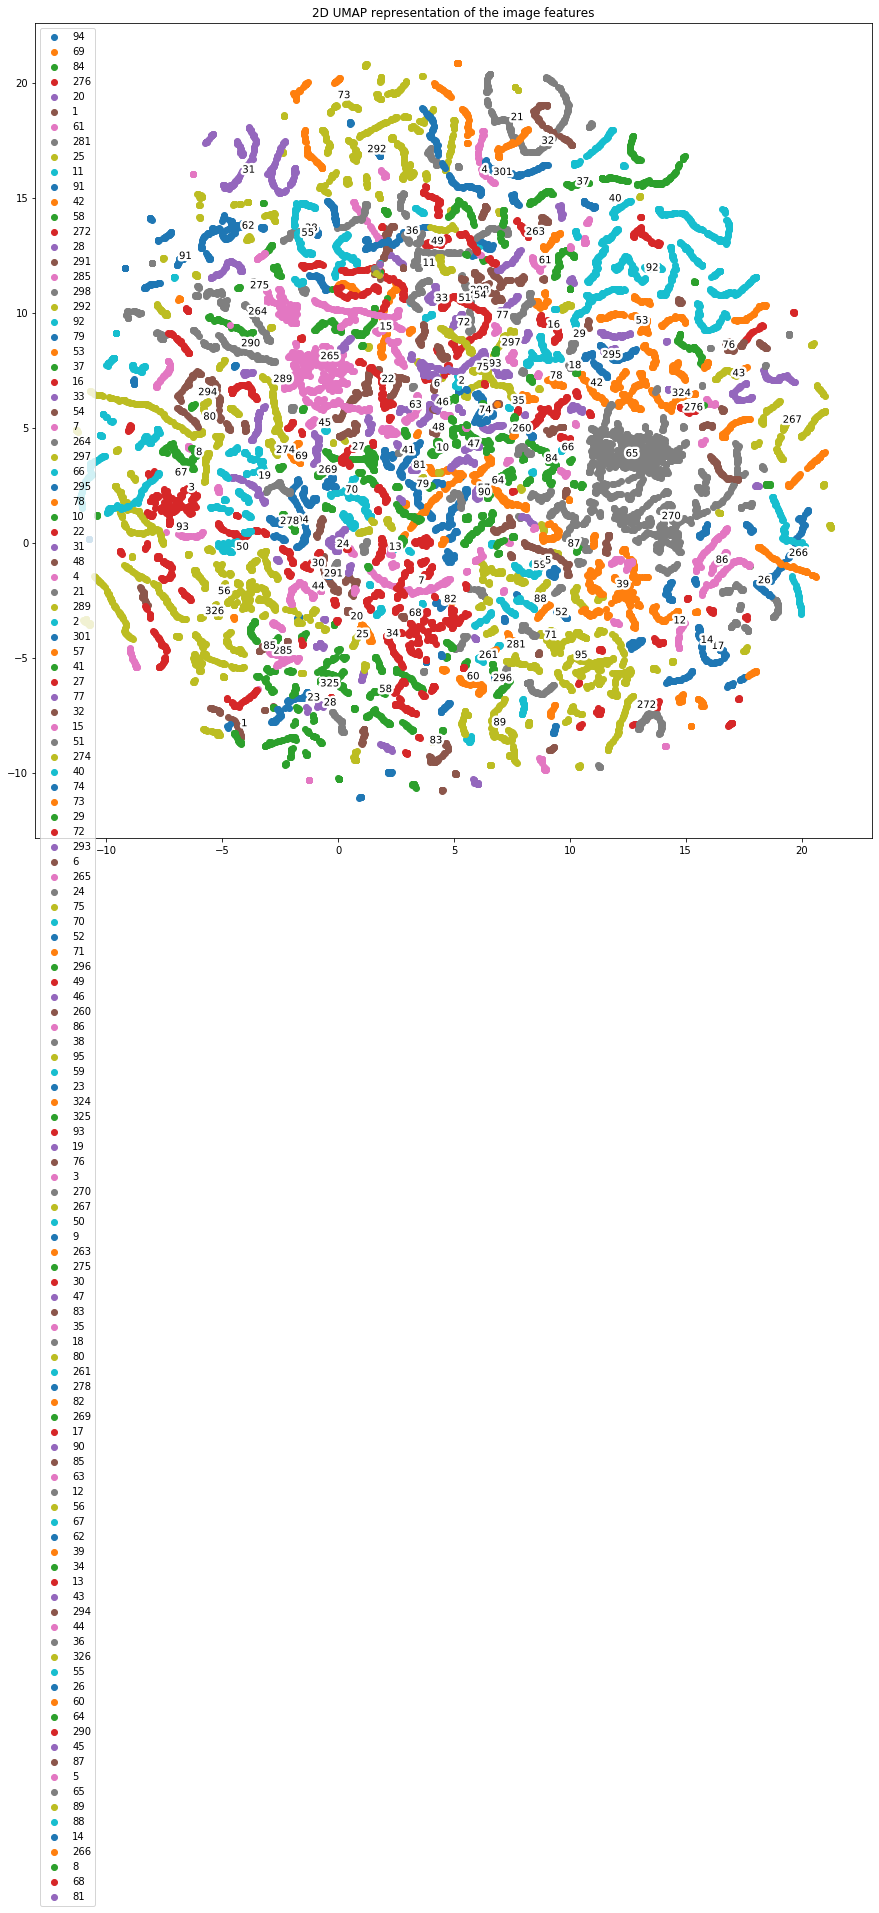

In [28]:
plot_embeddings_umap(train_embeddings_cl, train_labels_cl, train_classes_dct)

positive distance : {0: (0, 0.3156970111071746)}
negative distance : {0: (0, 0.306974345436463)}


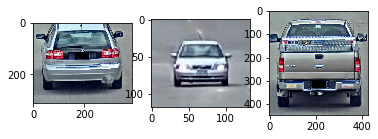

In [21]:
# anchor image
img1 = cv2.imread('aicity_cars_dataset/test/242/S03_c010_218.png')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img1 = Image.fromarray(img1)

# positive image
img2 = cv2.imread('aicity_cars_dataset/test/242/S03_c014_71.png')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
img2 = Image.fromarray(img2)

# negative image
img3 = cv2.imread('aicity_cars_dataset/test/245/S03_c010_711.png')
img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)
img3 = Image.fromarray(img3)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)

img1 = img_transforms(img1)
img2 = img_transforms(img2)
img3 = img_transforms(img3)

img1 = img1.unsqueeze(0)
img2 = img2.unsqueeze(0)
img3 = img3.unsqueeze(0)

img1 = img1.to(device)
img2 = img2.to(device)
img3 = img3.to(device)

model=model.to(device)
model.eval()

with torch.no_grad():
    anchor, positive, negative = model(img1, img2, img3)

anchor.data.cpu().numpy()
positive.data.cpu().numpy()
negative.data.cpu().numpy()

## Hellinger distance
# distance_positive = getDistances(cv2.HISTCMP_HELLINGER, [(0,0,anchor.data.cpu().numpy())], positive.data.cpu().numpy())
# print(f'positive distance : {distance_positive}')

# distance_negative = getDistances(cv2.HISTCMP_HELLINGER,[(0,0,anchor.data.cpu().numpy())], negative.data.cpu().numpy())
# print(f'negative distance : {distance_negative}')

## 
distance_positive = getDistances(cv2.HISTCMP_BHATTACHARYYA, [(0,0,anchor.data.cpu().numpy())], positive.data.cpu().numpy())
print(f'positive distance : {distance_positive}')

distance_negative = getDistances(cv2.HISTCMP_BHATTACHARYYA,[(0,0,anchor.data.cpu().numpy())], negative.data.cpu().numpy())
print(f'negative distance : {distance_negative}')


## L2 Norm
# distance_positive = torch.norm(anchor - positive, 2, dim=0)
# print(f'positive distance : {distance_positive}')

# distance_negative = torch.norm(anchor - negative, 2, dim=0)
# #distance_negative = (anchor - negative).pow(2).sum(1)
# print(f'negative distance : {distance_negative}')